# DLib的一次尝试使用

In [1]:
import os
import dlib
import numpy as np
from glob import glob
from PIL import Image, ImageDraw
from collections import defaultdict

In [2]:
def draw_boxs(img, dets):
    '''
    显示检测框
    '''
    if isinstance(img, Image.Image):
        img = img.copy()
    else:
        img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for face in dets:
        draw.rectangle([(face.left(), face.top()), (face.right(), face.bottom())], outline='red')
    return img

def draw_landmark(img, shape, radius=2):
    '''
    画点
    '''
    if isinstance(img, Image.Image):
        img = img.copy()
    else:
        img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for point in shape.parts():
        draw.ellipse((point.x - radius, point.y - radius, point.x + radius, point.y + radius), fill=(0, 0, 255))
    return img

In [3]:
# 人脸正脸检测器
detector = dlib.get_frontal_face_detector()
cnn_face_detector = dlib.cnn_face_detection_model_v1('dlib_dat/mmod_human_face_detector.dat')


In [4]:
img = dlib.load_rgb_image('images/d11.jpg')

# 人脸检测部分

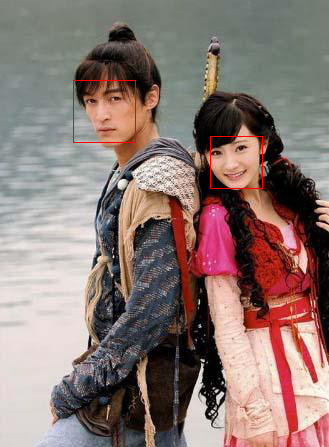

In [5]:
dets = detector(img, 1)
#可以让探测器告诉你对于每个检测的分数。更自信的检测得分更高。要运行的第三个参数是对检测阈值的可选调整，负数会返回更多的检测，而正值会返回更少的检测。同时，idx会告诉你哪个脸部子探测器匹配。这可以用于广泛识别不同方向的面孔。
# dets, scores, idx = detector.run(img, 1, 0.5)
draw_boxs(img, dets)

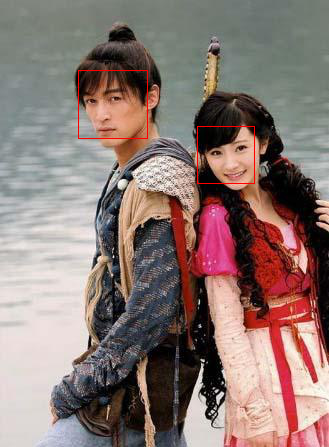

In [6]:
# 使用CNN人脸检测器
cnn_dets = cnn_face_detector(img, 1)
rects = dlib.rectangles()
rects.extend([d.rect for d in cnn_dets])
draw_boxs(img, rects)

# 人脸矫正部分

In [7]:
# 关键点预测器：分别为5和68
predictor_landmark_5 = dlib.shape_predictor('dlib_dat/shape_predictor_5_face_landmarks.dat')
predictor_landmark_68 = dlib.shape_predictor('dlib_dat/shape_predictor_68_face_landmarks.dat')

## 绘制5个关键点

Detection 0: Left: 73 Top: 80 Right: 135 Bottom: 142
Part 0: (120, 99), Part 1: (110, 100) ...
Detection 1: Left: 210 Top: 136 Right: 262 Bottom: 188
Part 0: (245, 147), Part 1: (235, 150) ...


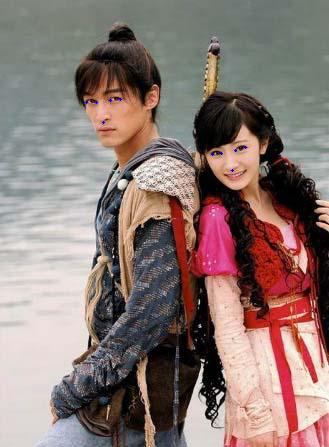

In [8]:
landmark_5_img = img
for k, det in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(k, det.left(), det.top(), det.right(), det.bottom()))
    shape = predictor_landmark_5(np.asarray(landmark_5_img, dtype=np.uint8), det)
    print("Part 0: {}, Part 1: {} ...".format(shape.part(0), shape.part(1)))
    landmark_5_img = draw_landmark(landmark_5_img, shape, 1)
landmark_5_img

## 绘制68个关键点

Detection 0: Left: 73 Top: 80 Right: 135 Bottom: 142
Part 0: (78, 104), Part 1: (79, 111) ...
Detection 1: Left: 210 Top: 136 Right: 262 Bottom: 188
Part 0: (205, 153), Part 1: (207, 160) ...


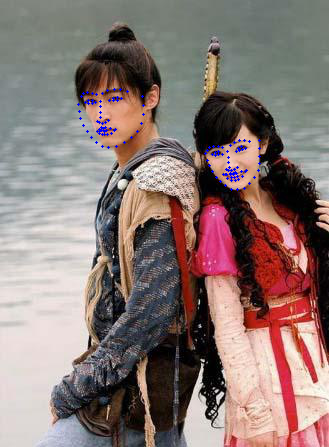

In [9]:
landmark_68_img = img
for k, det in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(k, det.left(), det.top(), det.right(), det.bottom()))
    shape = predictor_landmark_68(np.asarray(landmark_68_img, dtype=np.uint8), det)
    print("Part 0: {}, Part 1: {} ...".format(shape.part(0), shape.part(1)))
    landmark_68_img = draw_landmark(landmark_68_img, shape, 1)
landmark_68_img

## 人脸对齐

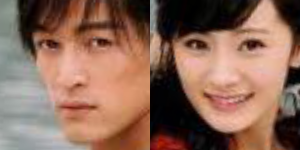

In [10]:
faces = dlib.full_object_detections()  # 对象检测对象的数组。
for detection in dets:
    faces.append(predictor_landmark_5(img, detection))  # 对每一个人脸检测关键点
images = dlib.get_face_chips(img, faces, size=150)  # 对人脸进行校正
Image.fromarray(np.concatenate(images, axis=1))

# 人脸聚类

In [11]:
# resnet人脸识别模型
facerec = dlib.face_recognition_model_v1('dlib_dat/dlib_face_recognition_resnet_model_v1.dat')

## 查找人脸

In [12]:
descriptors = []
images = []
for f in glob('images/*.jpg'):
    # 读取图像
    img = dlib.load_rgb_image(f)
    print("Processing file: {}".format(f))
    # 让检测器找到每个面的边界框。第二个参数中的1表示我们应该对图像进行一次上采样。这将使一切变得更大，并允许我们检测更多的脸。
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    # 现在处理我们找到的每一张脸。
    for k, detection in enumerate(dets):
        # 找到这个人脸box中的landmarks/parts
        shape = predictor_landmark_5(img, detection)
        # 计算由shape标识的img中描述人脸的128D向量。
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        descriptors.append(face_descriptor)
        images.append((img, shape))


Processing file: images\10.jpg
Number of faces detected: 1
Processing file: images\11.jpg
Number of faces detected: 0
Processing file: images\13.jpg
Number of faces detected: 1
Processing file: images\14.jpg
Number of faces detected: 1
Processing file: images\15.jpg
Number of faces detected: 1
Processing file: images\16.jpg
Number of faces detected: 0
Processing file: images\17.jpg
Number of faces detected: 0
Processing file: images\18.jpg
Number of faces detected: 1
Processing file: images\19.jpg
Number of faces detected: 0
Processing file: images\2.jpg
Number of faces detected: 1
Processing file: images\20.jpg
Number of faces detected: 1
Processing file: images\21.jpg
Number of faces detected: 3
Processing file: images\22.jpg
Number of faces detected: 3
Processing file: images\3.jpg
Number of faces detected: 0
Processing file: images\4.jpg
Number of faces detected: 2
Processing file: images\5.jpg
Number of faces detected: 2
Processing file: images\6.jpg
Number of faces detected: 2
Pr

## 脸聚人脸

In [13]:
labels = dlib.chinese_whispers_clustering(descriptors, 0.4)
num_classes = len(set(labels))
print("Number of clusters: {}".format(num_classes))

Number of clusters: 40


## 按照标签进行汇总

In [14]:
clusters = defaultdict(list)
for index, label in enumerate(labels):
    clusters[label].append(images[index])
rows = []
max_col_size = 0
for k in clusters.keys():
    cols = []
    for img, shape in clusters[k]:
        cols.append(dlib.get_face_chip(img, shape, size=80, padding=0.25))
    if max_col_size < len(cols):
        max_col_size = len(cols)
    rows.append(np.concatenate(cols, axis=1))
for i, row in enumerate(rows):
    width = row.shape[1]
    if max_col_size * 150 > width:
        rows[i] = np.concatenate([row, np.zeros((row.shape[0], max_col_size * 80 - row.shape[1], row.shape[2]), dtype=np.uint8) + 255], axis=1)
full_image = np.concatenate(rows)

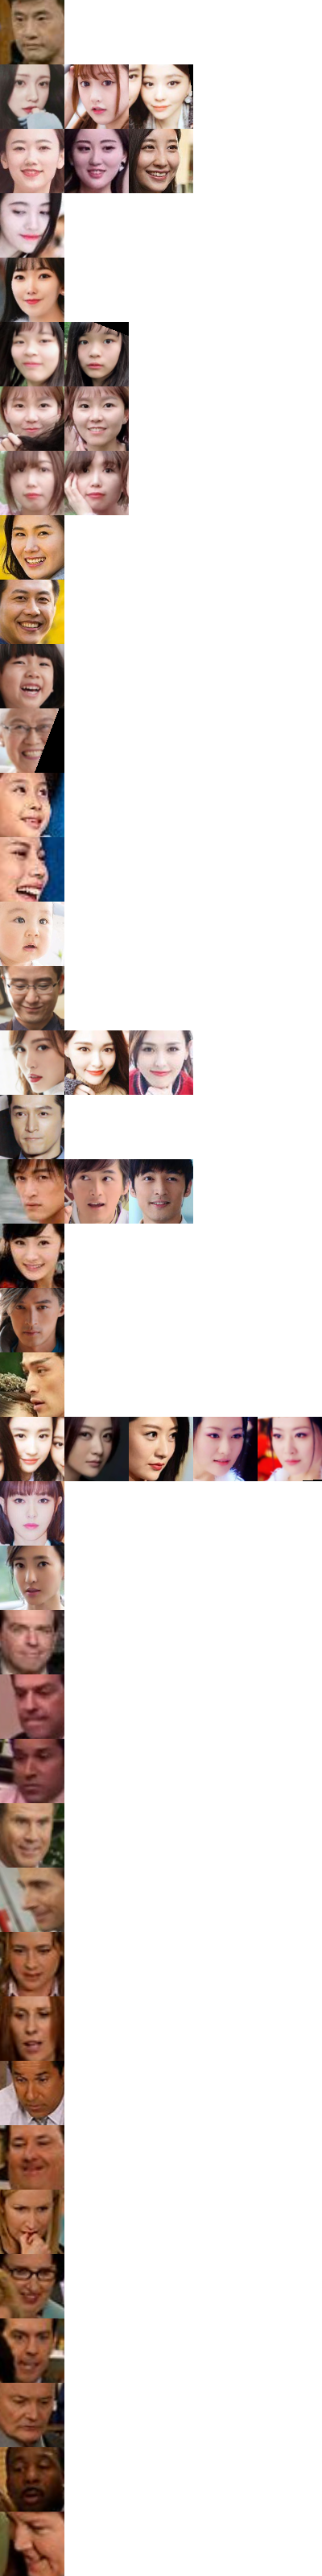

In [15]:
Image.fromarray(full_image)